# Problem Set 5 - K-Means, SVM , Neural Networks, and Q-learning
## CSCI 5622 - Fall 2022

***
**Name**: $<$insert name here$>$
***

This assignment is due on Canvas by **11.59 PM on Wednesday, December 7th**.
Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
The last bonus problem will require additional files to be submitted. We'll explain its submission format later.

Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import tests
import data

# Assignment Setup

For this problem set, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 6 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`X`, `labels`) attributes that are split into `train` and `test` partitions.
In the first problem, we'll be implementing K-means and evaluate it on the `multi_blobs` data.
In the second problem, we'll be implementing Support Vector Machines (SVM) with the kernel trick and test it on `circles` and `binary_blobs`.
And in the last problem, we'll implement our Multi-Layer Perceptron from scratch and test it on the `circles` dataset.

All different problems are entirely independent and could be solved in any order you deem fitting.

For this semester, we've also added a bonus problem on deep reinforcement learning (Deep Q-Learning) to get you familiar with its concepts and some of its practical limitations.


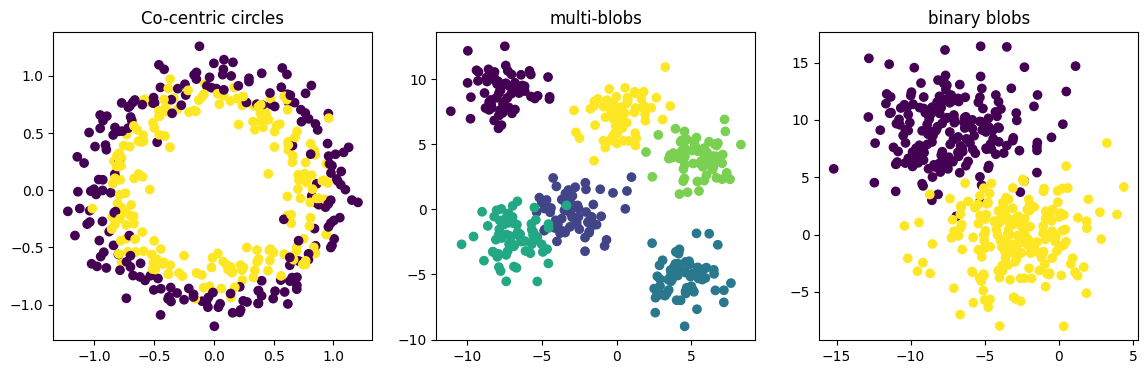

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
circles_offset = data.Circles(mode="-1/1")
multi_blobs = data.DataBlobs(centers=6, std=1.3)
binary_blobs = data.DataBlobs(centers=2, std=2.7)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (multi_blobs, "multi-blobs"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

# Problem 1 : K-means (30 points)

The goal of K-means is to partition the data into $k$ clusters such that the sum of intra-cluster variances is minimal.
We will be using Euclidean distance as our variance measure, so for cluster $C_i = \{x_1,x_2,... x_{m_i}\}$, its intra-cluster variance $V(C_i)$ is defined as:

$$
V(C_i) = \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

where $\mu_i = \frac{1}{m} \sum_{i=1}^{m_i} x_i$. $\mu_i$ is called the centroid of cluster $C_i$.

So for $k$ clusters, K-means objective is:
$$
\min_{C_1,C_2\ldots C_k}\sum_{i=1}^{k}V(C_i) = \min_{C_1,C_2\ldots C_k} \sum_{i=1}^{k} \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

Each sample $x_i$ is assigned to the cluster of the closest centroid. Hence, finding the optimal partition $\{C_1,C_2...C_k\}$ that minimizes the objective is equivalent to finding the optimal centroids.

Unfortunately, there is no algorithm that reaches the global optima for K-means, but we'll be implementing the most famous heuristic for the problem: Llyod algorithm. It works as follows:

- Initialize the centroids with **unique** random samples (`initialize_centroids`), initial objective = $+\infty$
- Repeat until convergence:
    - Compute the distances matrix $D$ between samples and centroids (`compute_distances`)
    - Use $D$ to assign each sample to the cluster with the closest centroid (`computes_assignments`)
    - Update the centroids as centers of the new cluster assignments (`compute_centroids`)
    - Compute the new objective (`compute_objective`)
    - Stop if the improvement ratio of the objective is less than $\epsilon$

The improvement ratio equal to `|new_objective - previous_objective|/|previous_objective|`.


- **1.1 [2 points]** `initialize_centroids` : select K **distinct** samples from the matrix data `X` and use them as the initial centroids. Store these centroids in the class attribute `self.centroids` as an `np.array` of shape $k \times d$.
- **1.2 [4 points]** `compute_distances` : compute the distance of each sample $x_i$ to every centroid $c_j$ and return the result as a matrix `distances_matrix` of size $N \times k$ where `N` is the number of samples and `k` is the chosen number of clusters to be found. The cell `(i,k)` shall contain the euclidean distance between sample $x_i$ and centroid $m_k$.
- **1.3 [2 points]** `compute_assignments` : given the distances matrix of size $N \times k$ return an array of labels in which each element is an integer in the range $[0, k-1]$ and it represents which centroid it's closest to.
- **1.4 [4 points]** `compute_centroids` : Compute the new centroids depending on the new set of samples that has been alloted to each cluster.
- **1.5 [6 points]** `fit` : This shall contain your main loop which implements the algorithm described above. You'll sequentially call the methods above to find the $k$ centroids. Break the loop when the improvement ratio of the objective is within `rtol`. At the end (or start, depending on how you code it) of each iteration, call the method `save_plot` to save the current clustering status and save the current objective value in the `history` list.
- **1.6 [3 points]** `predict` : Given new samples, return their assigned clusters that were learned in the `fit` step.

While we're working on 2-d data (d=2) for visualization purposes, your implementation should handle any number of features.

In [3]:
class KMeans:
    def __init__(self, k, rtol=1e-3):
        """
        :param k: (int) number of means/centroids to evaluate
        :param rtol: (float) relative tolerance, `epsilon` from the markdown
        """
        self.k = k
        self.centroids = None
        self.snapshots = []  # buffer for progress plots
        self.rtol = rtol

    def initialize_centroids(self, X):
        """
        Randomly select k **distinct** samples from the dataset in X as centroids
        @param X: np.ndarray of dimension (num_samples, num_features)
        @return: centroids array of shape (k, num_features)
        """
        centroids = None
        # Workspace 1.1
        #BEGIN
        centroids = X[np.random.choice(range(X.shape[0]), size=self.k, replace=False)]
        #END
        return centroids

    def compute_distances(self, X):
        """
        Compute a distance matrix of size (num_samples, k) where each cell (i, j) represents the distance between
        i-th sample and j-th centroid. We shall use Euclidean distance here.
        :param X: np.ndarray of shape (num_samples, num_features)
        :return: distances_matrix : (np.ndarray) of the dimension (num_samples, k)
        """
        distances_matrix = np.zeros((X.shape[0], self.k))
        # Workspace 1.2
        #BEGIN
        gram_matrix = X.dot(self.centroids.T)
        distances_square = ((np.linalg.norm(X, axis=1) ** 2)[:, None] + (np.linalg.norm(self.centroids, axis=1) ** 2)[
                                                                       None, :] - 2 * gram_matrix)
        distances_matrix = np.abs(distances_square) ** 0.5  ## abs because of floating errors (small negative value)
        #END
        return distances_matrix

    @staticmethod
    def compute_assignments(distances_to_centroids):
        """
        Compute the assignment array of shape (num_samples,) where assignment[i] = j if and only if
        sample i belongs to the cluster of centroid j
        :param distances_to_centroids: The computed pairwise distances matrix of shape (num_samples, k)
        :return: assignments array of shape (num_samples,)
        """

        assignments = np.zeros((distances_to_centroids.shape[0],))

        # Workspace 1.3
        #BEGIN
        assignments = np.argmin(distances_to_centroids, axis=1)
        #END
        return assignments

    def compute_centroids(self, X, assignments):
        """
        Given the assignments array for the samples, compute the new centroids
        :param X: data matrix of shape (num_samples, num_features)
        :param assignments: array of shape (num_samples,) where assignment[i] is the current cluster of sample i
        :return: The new centroids array of shape (k, num_features)
        """
        # Workspace 1.4
        centroids = np.zeros((self.k, X.shape[1]))
        #BEGIN

        for i in range(self.k):
            elements = (assignments == i)
            if np.sum(elements) != 0:
                centroids[i] = np.mean(X[elements], axis=0)
        #END
        return centroids

    def compute_objective(self, X, assignments):
        return np.sum(np.linalg.norm(X - self.centroids[assignments], axis=1) ** 2)

    def fit(self, X):
        """
        Implement the K-means algorithm here as described above. Loop until the improvement ratio of the objective
        is lower than rtol. At the end of each iteration, save the k-means objective and return the objective values
        at the end

        @param X:
        @return:
        """
        self.centroids = self.initialize_centroids(X)
        objective = np.inf
        assignments = np.zeros((X.shape[0],))
        history = []

        # Workspace 1.5

        while True:
            self.save_snapshot(X, assignments)
            #BEGIN
            distances_to_centroids = self.compute_distances(X)
            assignments = self.compute_assignments(distances_to_centroids)
            self.centroids = self.compute_centroids(X, assignments)
            new_objective = self.compute_objective(X, assignments)
            if objective!= np.inf and np.abs(objective - new_objective) / (objective + 1e-8) < self.rtol:
                break
            objective = new_objective
            history.append(objective)
            #END
        return history

    def predict(self, X):
        # Workspace 1.6
        assignments = np.zeros((X.shape[0],))
        #BEGIN
        distances_to_centroids = self.compute_distances(X)
        assignments = self.compute_assignments(distances_to_centroids)
        #END
        return assignments

    def save_snapshot(self, X, assignments):
        """
        Saves plot image of the current asssignments
        """
        if X.shape[1] == 2:
            self.snapshots.append(tests.create_buffer(X, assignments))

In [4]:
%matplotlib notebook
# show progress code
k_means = KMeans(6)
objective_history = k_means.fit(multi_blobs.X)
tests.show_progress(k_means.snapshots)

## Evaluating K-means
The easiest way to evaluate the clustering quality is to use the true labels. The natural question here is: which cluster corresponds to which label?

Let's first formulate the question using `multi_blobs` dataset. We have 5 clusters and 5 classes in our data. Let's create a _confusion matrix_ $C$ between the clusters and the labels so that $ C_{i,j} = \text{size}(\text{cluster}_i \cap \text{class}_j)$.

We model the unknown mapping using the $6\times 6$ boolean matrix $X$ such that $X_{i,j}=1$ if and only if $\text{cluster}_i$ is mapped to $\text{class}_j$.

To avoid having a cluster assigned to multiple classes, each row of $X$ is constrained to have only one non-zero entry.

Now, given a mapping $X$ and confusion matrix $C$, the number of correctly "classified" samples (not really classification, more of clustering here) is:

\begin{align}
\#\text{correct} = \sum_i \sum_j C_{i,j} X_{i,j}
\end{align}
The goal is to find $\hat{X}$ that maximizes $\#\text{correct}$. To solve for $X$ we're going to use `scipy`'s `linear_sum_assignment`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)).

- **1.7 [5 points]** Complete `evaluate_clustering` to return the accuracy of K-means using the optimal mapping $\hat{X}$
defined above.

In [5]:
from scipy.optimize import linear_sum_assignment


def evaluate_clustering(trained_model, X, labels):
    """
    Compute the ratio of correct matches between clusters from the trained model and the true labels
    :param trained_model: Unsupervised learning model that predicts clusters
    :param X: samples array, shape (num_samples, num_features)
    :param labels: true labels array, shape (num_samples,
    :return:
    """
    # We can assume that the number of clusters and the number of class labels are the same
    clusters = trained_model.predict(X)
    # Workspace 1.7
    #BEGIN
    # create the confusion matrix and use `linear_sum_assignment` to find X_hat
    # Transform the cluster assignments to predicted labels using X_hat then compute and return the accuracy
    accuracy = 0
    confusion = np.eye(6)[clusters].T.dot(np.eye(6)[labels])
    _, col_ind = linear_sum_assignment(cost_matrix=confusion, maximize=True)
    predicted_labels = col_ind[clusters]
    accuracy = np.mean(predicted_labels == labels)
    ""
    #END
    return accuracy

- **1.8 [4 points]** Run K-means on the full `multi_blobs` for 20 times. Plot the histogram (`plt.hist`) of the clustering evaluation from `evaluate_clustering`. Also report the mean clustering performance

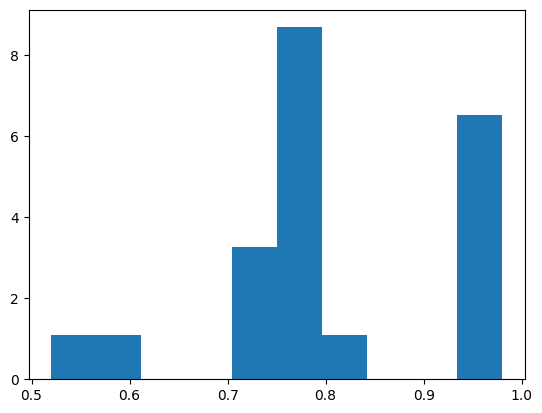

0.805625


In [6]:
%matplotlib inline
accuracies = []
# Workspace 1.8
#BEGIN
for _ in range(20):
    k_means = KMeans(6)
    objective_history = k_means.fit(multi_blobs.X)
    accuracy = evaluate_clustering(k_means, multi_blobs.X, multi_blobs.labels)
    accuracies.append(accuracy)

plt.hist(accuracies, density=True)
plt.show()
print(np.mean(accuracies))
#END


## K-means++ (Bonus)
We have used a random centroid initialization in K-means. In K-means++, we initialize the centroids
in a (slightly) smarter way, and it works as the following:
- Choose the first centroid uniformly at random from the data samples
- For the subsequent centroids:
    - compute the distances $(d_i)$ between the data samples and the current centroids (distance between a sample and its nearest centroid)
    - Pick a new centroid randomly with probability proportional to $d_i ^2$ (not $d_i$!).


The rest of _K-means++_'s algorithm is exactly the same as _K-means_

- **1.9 (Bonus question) [4 points]**  Complete the `initialize_centroids` of K-means++ class and report K-means++ performance in a similar way to 1.8. Which model is better?

 You do not have to implement other methods. `KMeansPP(Kmeans)` implies that `KMeansPP` will inherit all the methods of `Kmeans` unless we choose to _override_ them (redefinition).

_Hint_: The weighted sampling can be done using `numpy`'s `choice` and its argument `p`. You do not have to worry about excluding the already picked centroids from the data. Once they're picked, their sampling weight should be equal to $0$. Make sure the probabilities sum to $1$.


In [7]:
class KMeansPP(KMeans):

    def initialize_centroids(self, X):
        #Workspace 1.9.a
        # Complete K-means++ centroid initialization. The first step (first centroid) is provided in the next line
        # Hint: You can modify self.centroids and use self.compute_distances to avoid re-coding distances computations
        centroids = X[np.random.choice(range(X.shape[0]), size=1)]
        #BEGIN
        self.centroids = centroids
        for _ in range(self.k - 1):
            distances_squared = self.compute_distances(X) ** 2
            min_distances_squared = np.min(distances_squared, axis=1)
            probas = min_distances_squared / np.sum(min_distances_squared)
            new_centroid = X[np.random.choice(range(X.shape[0]), size=1, p=probas)]
            self.centroids = np.concatenate([self.centroids, new_centroid], axis=0)
        centroids = self.centroids
        #END
        return centroids

In [8]:
%matplotlib notebook
k_means_pp = KMeansPP(6)
objective_history = k_means_pp.fit(multi_blobs.X)
tests.show_progress(k_means_pp.snapshots)

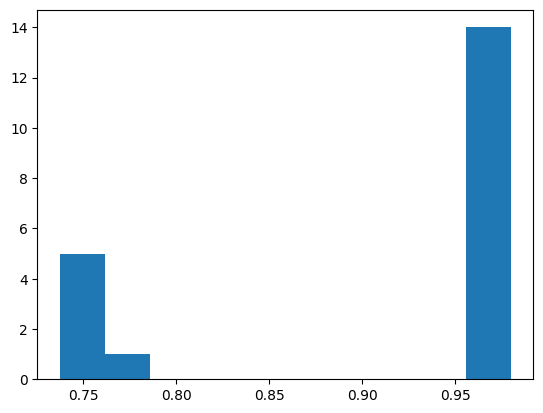

0.9113750000000002


In [9]:
%matplotlib inline
accuracies = []
# Workspace 1.9.b
# Redo 1.8 using KMeansPP
#BEGIN
for _ in range(20):
    k_means = KMeansPP(6)
    objective_history = k_means.fit(multi_blobs.X)
    accuracy = evaluate_clustering(k_means, multi_blobs.X, multi_blobs.labels)
    accuracies.append(accuracy)

plt.hist(accuracies)
plt.show()
print(np.mean(accuracies))
#END

### Workspace 1.9.c
% Which model is better?

% BEGIN

% END

# Problem 2: Classification using Support Vector Machines and Kernel Trick (25 points)

We have seen during the class the dual form of the Support Vector Machine problem using a kernel $K$:

\begin{aligned}
 \max_{\alpha} \Big[ \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)}) \Big]
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

The simplest kernel $K$ is the linear kernel 
\begin{align}
K_{lin}(x^{(i)},x^{(j)}) = <x^{(i)}, x^{(j)}>
\end{align}
 with $<.,.>$ being the scalar product.

 We'll be also using the radial kernel $K_{rad}$:
\begin{align}
 K_{rad, \gamma}(x^{(i)},x^{(j)})  = \exp \big[-\gamma ||x^{(i)} - x^{(j)}||^2]
\end{align}
And the polynomial kernel $K_{poly, c, p}$ with parameters $c$ (offset) and $p$ (degree).
\begin{align}
 K_{poly, c, p}(x^{(i)},x^{(j)})  = (<x^{(i)}, x^{(j)}> + c)^p
\end{align}

- **2.1. [6 pts]** Complete the implementation of the three kernels defined above

In [10]:
class LinearKernel(object):

    def __init__(self, **kwargs):
        pass
    def compute_kernel(self, X1, X2):
        """
        Compute the kernel matrix
        @param X1: array of shape (m1, d)
        @param X2: array of shape(m2, d)
        @return: K of shape (m1, m2) where K[i,j] = <X1[i], X2[j]>
        """
        # Workspace 2.1.a
        K = np.zeros((X1.shape[0], X2.shape[0]))
        #BEGIN
        K = X1.dot(X2.T)
        #END
        return K


class RadialKernel(object):

    def __init__(self, gamma, **kwargs):
        self.gamma = gamma

    def compute_kernel(self, X1, X2):
        """
        Compute the kernel matrix. Hint: computing the squared distances is similar to compute_distances in K-means
        @param X1: array of shape (m1, d)
        @param X2: array of shape(m2, d)
        @return: K of shape (m1,m2) where K[i,j] = K_rad(X1[i],X2[j]) = exp(-gamma * ||X1[i] - X2[j]||^2)
        """
        # Workspace 2.1.b
        K = np.zeros((X1.shape[0], X2.shape[0]))
        #BEGIN
        gram_matrix = X1.dot(X2.T)
        distances_square = ((np.linalg.norm(X1, axis=1) ** 2)[:, None] + (np.linalg.norm(X2, axis=1) ** 2)[None,
                                                                         :] - 2 * gram_matrix)
        K = np.exp(-self.gamma * distances_square)
        #END
        return K


class PolynomialKernel(object):

    def __init__(self, c, p, **kwargs):
        self.c = c
        self.p = p

    def compute_kernel(self, X1, X2):
        """
        Compute the kernel matrix.
        @param X1: array of shape (m1, d)
        @param X2: array of shape(m2, d)
        @return: K of shape (m1,m2) where K[i,j] = (X1[i].X2[j] + c)^p
        """
        # Workspace 2.1.b
        K = np.zeros((X1.shape[0], X2.shape[0]))
        #BEGIN
        K = (X1.dot(X2.T) + self.c) ** self.p
        #END
        return K

We add a ridge regularization of $\alpha$ with coefficient $\beta$, this time there is a minus $-$ since we're maximizing (so that $\beta ||\alpha||^2$ is minimized).
\begin{aligned}
 \max_{\alpha} \Big[ \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)}) - \frac{\beta}{2} ||\alpha||^2 \Big]
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}


Now we'll solve for $\alpha$ of the dual form  using the quadratic solver from [`cvxopt` package](https://cvxopt.org/userguide/coneprog.html#quadratic-programming) (we're using version 1.3.0, it might affect the sanity checks if its different).
To match the solver API, we need to rewrite the problem as:

\begin{aligned}
    \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ Gx \leq h
    \\
    \ Ax = b
\end{aligned}

So we'll define $P, q, G, h, A, b$  as:

\begin{align}
\mathrm{P}_{i,j} &= y^{(i)}y^{(j)} \mathrm{K}(x^{(i)},x^{(j)}) + \beta \delta_{i,j} \text{,  matrix $\mathrm{P}$ is of shape $m\times m$}\\
q &= -\overline{1} \text{,  vector of size m where are elements = -1} \\
\mathrm{G} &= diag(-\overline{1}) = -I_m\text{, diagonal matrix of -1} \\
h &= \overline{0} \text{,  vector of size m  where are elements = 0} \\
\mathrm{A} &= y \text{, the labels array in \{-1, 1\}} \\
b &= 0 \text{, a scalar (not to confused with the intercept of SVM)}
\end{align}

$\delta_{i,j} = 1$ if $i=j$ and $0$ otherwise.

Hint: We're basically computing $\mathrm{P}$ so that $ \mathrm{P}_{i,j} = y^{(i)}y^{(j)} \mathrm{K}(x^{(i)},x^{(j)})$ and then we add $\beta. \mathrm I$ where $\mathrm I$ is the identity matrix.

- **2.2 [4 points]** Complete `quadratic_solver` by computing the array $P$ as defined above. We provide $q, G, h, A$ and the scalar $b$. Make sure that $P$ has the correct shape.


In [11]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np

solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10


def quadratic_solver(K, y, beta):
    """

    :param K: Kernel matrix K of shape (m,m)
    :param y: array of binary labels {-1, 1} of shape (m,)
    :param beta: ridge regularization coefficient
    :return: optimal alphas of shape (m,)
    """

    # Workspace 2.2
    m = K.shape[0]
    #P = ? # shape (m,m)
    
    #BEGIN
    P = (K * y.reshape(-1, 1)) * y.reshape(1, -1) + beta * np.eye(m)  # shape (m,m)
    #END
    
    # The other values we need for optimization
    q = -np.ones((m, 1))        # shape(m,1)
    G = -np.eye(m)              # shape(m,m)
    h = 0.0 * np.zeros(m)       #shape (m,)
    A = 1.0 * y.reshape(1, -1)  # shape (1,m)
    b = 0.0                     # scalar
    # Quadratic solver
    sol = solvers.qp(P=matrix(P.astype(float)),
                     q=matrix(q.astype(float)),
                     G=matrix(G.astype(float)),
                     h=matrix(h.astype(float)),
                     A=matrix(A.astype(float)),
                     b=matrix(b))
    alphas = np.array(sol['x'])
    alphas = alphas * (np.abs(alphas) > 1e-8)  # zeroing out the small values
    return alphas.reshape(-1)

Once we get the optimal $\alpha$, then we can get the indices of the support vectors $S = \{i | \alpha_i >0 \}$. The intercept $b$ is computed as:

\begin{align}
b = \frac{1}{|S|}\sum_{m\in S}\big[ y^{(m)} - \sum_{i\in S} \alpha_i  y^{(i)}K(x^{(i)}, x^{(m)})\big]
\end{align}

and the prediction for a point $x$ would be:

\begin{align}
\hat{y} = \text{sign}\big[\sum_i y^{(i)}\alpha_i K(x,x^{(i)}) + b \big]
\end{align}

(you can see that we only need the features to compute the kernel $K$ and everything else is done as a function of the kernel. That's the beauty of kernel methods!).

- **2.3 [4 points]** Complete the `fit` method of SVM. _Hint_: Make sure to use the labels stored in `SVM.y` that have values (-1,1) instead of the (0,1) training labels

- **2.4 [3 points]** Complete the `predict` method to return the predicted $\{0,1\}$ labels of the provided samples.


In [12]:
class SVM(object):

    def __init__(self, kernel, beta=0.001):
        self.kernel = kernel
        self.X = None  # training features
        self.y = None  # training labels
        self.intercept = None
        self.alphas = None
        self.beta = beta  # ridge regularization coefficient

    def fit(self, X, y):
        """
        Transform y to (-1,1) and use self.kernel to compute K
        Solve for alphas and compute the intercept using the provided expression
        Keep track of X and y since you'll need them for the prediction
        @param X: data points of shape (num_samples, num_features)
        @param y: (0,1) labels of shape (num_samples,)
        @return: self
        """
        # Workspace 2.3
        self.X = X
        self.y = 2 * y - 1  # transforms 0,1 to -1, 1
        #BEGIN
        K = self.kernel.compute_kernel(X, X)
        self.alphas = quadratic_solver(K, self.y, self.beta)
        self.intercept = 0
        for m in np.where(self.alphas != 0)[0]:
            self.intercept += self.y[m] - np.sum(self.alphas * self.y * K[:, m])
        self.intercept = self.intercept / np.sum(self.alphas != 0)
        #END
        return self

    def predict(self, X):
        """
        Predict the labels of points in X
        @param X: samples array of shape (num_samples, num_features)
        @return: predicted 0-1 labels of shape (m,)
        """
        # Workspace 2.4
        predicted_labels = np.zeros((X.shape[0],))
        #BEGIN
        predicted_sign = np.sign(
            np.sum((self.y * self.alphas).reshape(-1, 1) * self.kernel.compute_kernel(self.X, X), axis=0)
            + self.intercept)
        predicted_labels = (1 + predicted_sign) / 2
        #END
        return predicted_labels

We provide below an example of the expected plots for this problem using the linear kernel. 

- **2.5 [2 points]** Edit the cell to report the accuracy on the test sets for each of the two datasets visualized in the plots. How do you explain the obtained accuracies?

[0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
[0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0.]


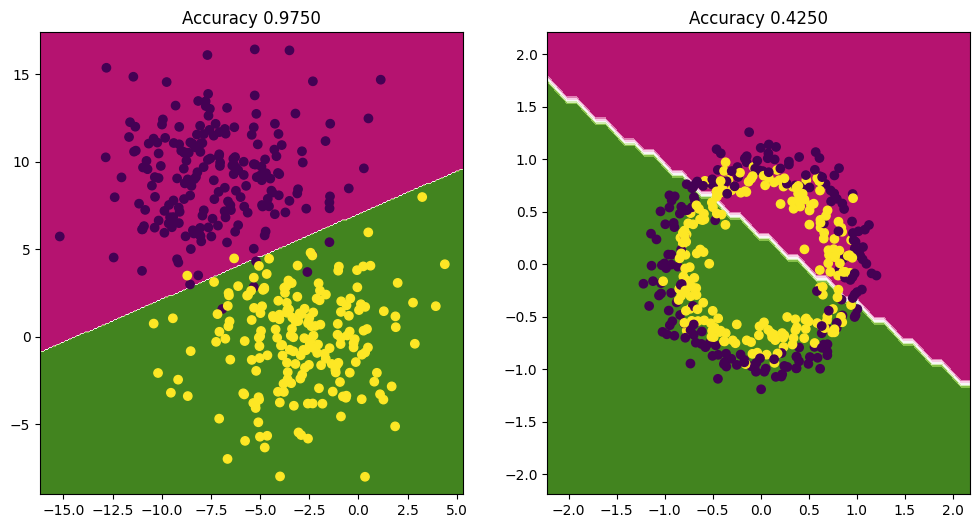

In [13]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
svm_linear = SVM(LinearKernel())
# Workspace 2.5.a
for i, dataset in enumerate([binary_blobs, circles]):
    svm_linear.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_linear, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN
    axs[i].set_title("Accuracy %0.4f" % np.mean(svm_linear.predict(dataset.X_test) == dataset.y_test))
    print(svm_linear.predict(dataset.X_test))
    #END
plt.show()

### Workspace 2.5.b
% Explain the observed performance

%BEGIN

%END

- **2.6 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the radial kernel with $\gamma=2.0$. Describe the model performance and compare it to the linear kernel.

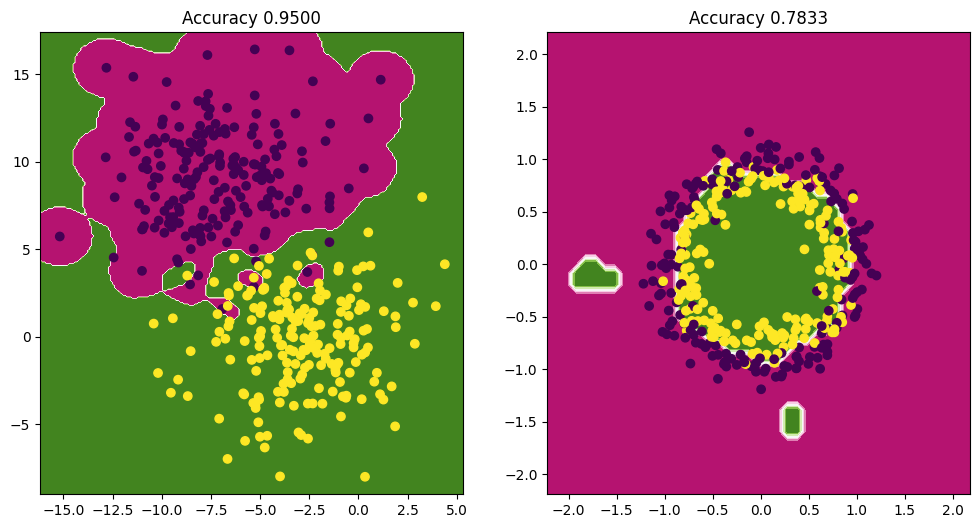

In [14]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.6.a
#BEGIN
svm_rad = SVM(RadialKernel(gamma=2.0))
for i, dataset in enumerate([binary_blobs, circles]):
    svm_rad.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_rad, dataset.X, dataset.labels, axs[i])
    axs[i].set_title("Accuracy %0.4f" % np.mean(svm_rad.predict(dataset.X_test) == dataset.y_test))
plt.show()
#END

### Workspace 2.6.b
% Explain the observed performance

%BEGIN

%END

- **2.7 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the polynomial kernel with $(c,p) = (1,5)$. Describe the model performance and compare it to the two previous kernels

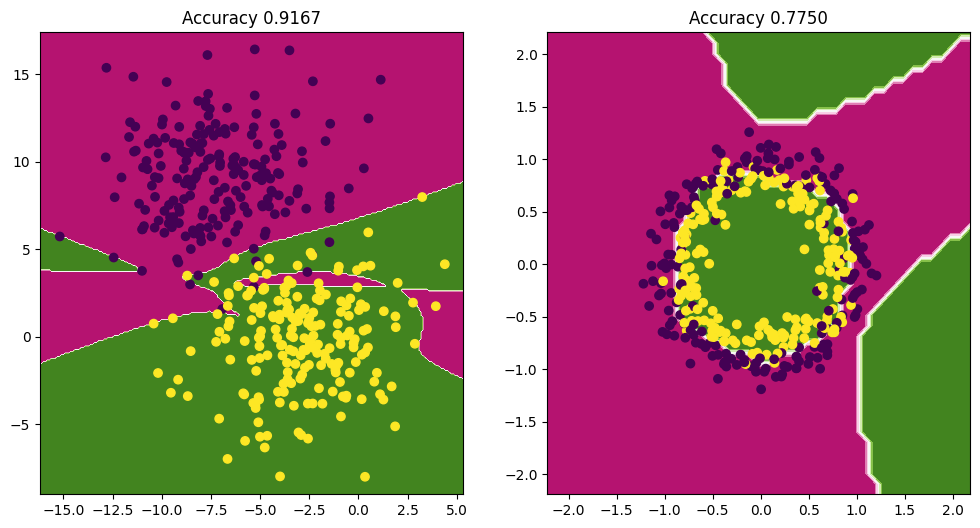

In [15]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.7.a
#BEGIN
svm_poly = SVM(PolynomialKernel(1.0, 5.0))
for i, dataset in enumerate([binary_blobs, circles]):
    svm_poly.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_poly, dataset.X, dataset.labels, axs[i])
    axs[i].set_title("Accuracy %0.4f" % np.mean(svm_poly.predict(dataset.X_test) == dataset.y_test))
plt.show()
#END

### Workspace 2.7.b
% Explain the observed performance

%BEGIN

%END

# Problem 3: Neural Networks (45 points)


In this final problem, we'll be implementing our own Neural Networks framework and use it to build a Multi-Layer Perceptron.
The MLP is a sequence of linear projections and activation functions, each of which will be implemented as a layer.

Each layer will have its own parameters (none for the activations), a `forward` method that applies the transformation,
and a `backward` method that back-propagates the gradient and computes the parameters gradients.

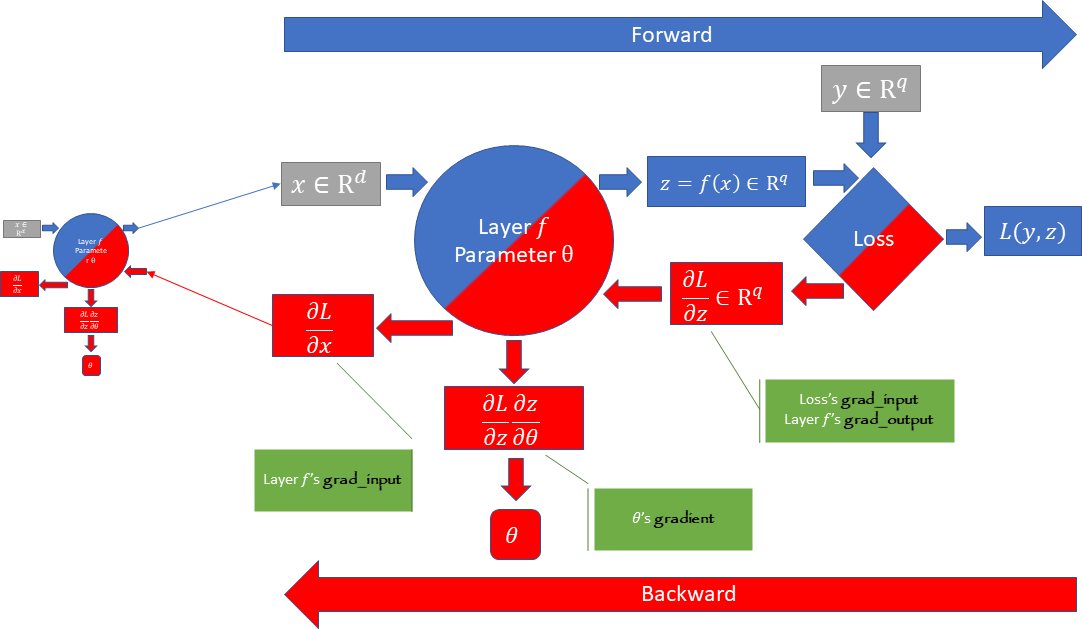
To understand how the mechanism works, let's consider the neural network that consists of one layer $f_\theta:  \mathbb{R}^d \mapsto \mathbb{R}^q$ where the parameter is optimized to minimize the loss $L$.

Our dataset consists of samples $(x_i)$ with $d$ features and a q-dimensional targets $(y_i)$. $f_\theta$ transforms  $(x_i)$ into $(z_i)$. We'll be using the Mean Squared Error (MSE) for the loss function $L$.

The neural network will have two passes:
 - forward pass where we transform the input into output,
 - and backward pass where we backpropagates the gradient and compute the gradient of the loss w.r.t to parameters.
 
Note that the gradient computation might require saving the input data from the forward pass since we won't be providing any data during the backward pass. We'll deal with that later.

Now, let's start from the layer $f_\theta: \mathbb{R}^d \mapsto \mathbb{R}^q$, with parameter $\theta$.

In order to compute the gradient for $\theta$, we first need the derivative of the loss w.r.t the layer's output $\frac{\partial L}{\partial z}$

We'll only deal with MSE loss defined as:
\begin{align}
MSE(y, z) = \frac{1}{m} \sum_{i=1}^{m} ||f_\psi(x_i) - y_i ||^2
\end{align}
, where $m$ is the sample size and $z_i = f_\theta(x_i)$.

The gradient of the loss w.r.t to its input $z$:

\begin{align}
 \frac{\partial MSE(y, z)}{\partial z}  = \frac{2}{m} (z - y)
\end{align}

- **3.1 [2 points]** Complete `MSE`'s `forward` method that returns the MSE between `y_pred` and `y_true`
- **3.2 [3 points]** Complete `MSE`'s `backward` method that returns the derivative w.r.t to the input `z`.

_Hint_: Notice that no argument is provided for the loss backward pass. You'll have to cache `y_pred` and `y_true` into your object-level `saved_arrays` variable during the `forward` call

In [16]:
class MSE:
    saved_arrays = []

    def forward(self, y_pred, y_true):
        """
        Compute the MSE loss
        @param y_pred: shape (m,q)
        @param y_true: shape (m,q)
        @return: scalar
        """
        # Workspace 3.1
        mse = 0
        #BEGIN
        self.saved_arrays = [y_pred, y_true]
        mse = np.sum(np.mean((y_pred - y_true) ** 2, axis=0))
        #END
        return mse

    def backward(self):
        """
        Compute the gradient w.r.t to the prediction y_pred
        You'll have to cache the necessary quantities into your object-level 
            `saved_arrays` variable during the forward pass
        @return: shape (m,q)
        """
        # Workspace 3.2
        grad_input = None
        #BEGIN
        y_pred, y_true = self.saved_arrays
        self.saved_arrays = None
        grad_input = 2 * (y_pred - y_true) / y_pred.shape[0]
        #END
        return grad_input

In [17]:
# Testing MSE
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
expected_mse = 0.17090547876852463
expected_grad = np.array([[-0.24193655, 0.04041597], [0.46728084, -0.25158067]])
mse = MSE()
assert np.isclose(mse.forward(mock_X, mock_X / 2), expected_mse)
assert np.alltrue(np.isclose(mse.backward(), expected_grad))


Now that we have the `grad_input` of `MSE`,  it's going to be `grad_output` from the perspective of the layer $f_\theta$.
- `grad_output` of layer $f_\theta$ is the derivative of the loss w.r.t to the layer's output (which is the next layer's input)
- `grad_input` of layer $f_\theta$ is the derivative of the loss w.r.t the layer's input

The `forward` method of a layer applies the transformation and keeps track of any relevant quantity for the gradient backpropagation.

The `backward` method is expected to return the gradient of the loss w.r.t to the layer's input using the chain rule.

In our implementation, we want to compute in each layer $f_\theta$:
- $\frac{\partial L }{\partial \theta} = \frac{\partial L }{\partial z} \frac{\partial z }{\partial \theta}$ is the `parameter.gradient` (if any)
- $\frac{\partial L }{\partial x} = \frac{\partial L}{\partial z} \frac{\partial f_\theta(x)}{\partial x}$, the the `grad_input` of layer $f$ and return it

The backward pass consists of sequentially doing what we've just mentioned for $f_\theta$

1. get the initial `grad_output` from loss layer (top layer)
2. In reverse order:
    - pass current `grad_output` to the next layer's backward
    - inside the layer's backward: compute `grad_input` and `parameter.gradient` (if there are any parameters)
    - `grad_output` <- `grad_input`
    - repeat 2
3. Loop through the parameters and apply the gradient

We'll apply this to our first layers: `hyperbolic tangent` and `ReLU`.
We don't have to worry about `parameter.gradient` since they don't have any parameters.

- **3.3 [5 points]** Complete the Hyperbolic Tangent ("Hyperbolic") activation layer. `forward` method applies the activation and `backward` should use the
chain rule to compute `grad_input` of the layer. You'll need to save the activation values to use them in `backward` call, for that you should use `self.saved_arrays` to cache them.

- **3.4 [5 points]** In a similar way, complete the ReLU activation layer. Note that $\frac{\partial \text{ReLU}(x)}{\partial x} = 1_{x\geq 0}$.

In [18]:
import numpy as np


class Layer(object):
    """
    Template Layer that will be used to implement all other layers
    """

    def __init__(self, name=""):
        self.saved_arrays = []  # You might need them for the backward pass
        self.parameters = []
        self.name = name  # to identify the layer

    def forward(self, x):
        """
        In the forward pass we receive an array containing the input and return an array containing the output.
        You can cache arbitrary objects for use in the backward pass in self.saved_arrays
        @param x: input array of size (batch_size, d)
        @return: output array
        """
        pass

    def backward(self, grad_output):
        """
        In the backward pass we receive an array containing the gradient of the loss with respect to the output,
        and we need to compute the gradient of the loss with respect to the input and the gradient of the weights (default as 0)
        @param grad_output:
        @return: grad
        """
        pass

class Hyperbolic(Layer):
    
    def forward(self, x):
        """
        Apply the hyperbolic tangent function to x. Don't forget to clip x to the interval [-25.0, 25.]
         before applying the activation
        @param x: input array of shape (batch_size, q)
        @return: element-size hyperbolic tangent of shape (batch_size, q)
        """
        
        # Recall that hyperbolic_tangent(x) = (e^x - e^-x)/(e^x + e^-x)
        
        hyperbolic = np.zeros_like(x)
        #BEGIN
        x_c = np.clip(x, -25, 25)
        hyperbolic = (np.exp(x_c) - np.exp(-x_c)) / (np.exp(x_c) + np.exp(-x_c))
        self.saved_arrays = [hyperbolic]
        #END
        return hyperbolic
    
    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return: grad_input of shape (batch_size, q)
        """
        grad_parameters = 0
        grad_input = 0
        #BEGIN
        hyperbolic, = self.saved_arrays
        grad_input = grad_output * (1 - hyperbolic ** 2)
        #END
        return grad_input

class ReLU(Layer):

    def forward(self, x):
        """
        Apply the ReLU function to x.
        @param x: input array of shape (batch_size, q)
        @return: element-size ReLU of shape (batch_size, q)
        """
        relu = 0
        # Workspace 3.4.a
        #BEGIN
        relu = x * (x > 0)
        self.saved_arrays = [x]
        #END
        return relu

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return:grad_input: of shape (batch_size, q)
        """
        grad_input = 0
        grad_parameters = 0
        # Workspace 3.4.b
        #BEGIN
        x, = self.saved_arrays
        grad_input = grad_output * (x > 0)
        #END
        return grad_input

In [19]:
# Hyperbolic Tangent Tests
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
grad_output = np.array([[0.19960269, 0.20993069], [-0.85814751, -0.41418101]])
hyp_x = np.array([[-0.44934008, 0.08065636], [0.73271362, -0.46459975]])
grad_hyp_x = np.array([[0.15930161, 0.208565], [-0.39743451, -0.32477883]])
hyperbolic = Hyperbolic()
assert np.alltrue(np.isclose(hyperbolic.forward(mock_X), hyp_x))
assert np.alltrue(np.isclose(hyperbolic.backward(grad_output), grad_hyp_x))

In [20]:
# ReLU Tests
relu_x = np.array([[-0., 0.08083195], [0.93456167, -0.]])
grad_relu_x = np.array([[0., 0.20993069], [-0.85814751, -0.]])
relu = ReLU()
assert np.alltrue(np.isclose(relu.forward(mock_X), relu_x))
assert np.alltrue(np.isclose(relu.backward(grad_output), grad_relu_x))

Now we'll move to the exciting part. We'll implement our own _dense_ (linear) layer that has two parameters $\theta=(w,b)$,
with $w$ being the weights array and $b$ the bias.
This layer $f_\theta$ projects a $d$ dimensional input into an $q$ dimensional space as follows:

\begin{align}
f_\theta(x) = xw + b
\end{align}

and its derivatives are:

\begin{align}
\frac{\partial f_\theta}{\partial x} &= w \\
\frac{\partial f_\theta}{\partial w} &= x^T \\
\frac{\partial f_\theta}{\partial b} &= 1_m
\end{align}

where $1_q$ is the ones vector with the same dimension as $b$


To help you keep track of the gradient, we will be wrapping the parameters numpy arrays using the `Parameter` class.
`Parameter` instances are an extension of numpy arrays, but they have additional:
 - attribute `gradient`: initialized with zeros and has the same shape as the array
 - method `zero_gradient`: resets the gradient values to zero
 - method `apply_gradient(grad)`: adds `grad` to the array
 - optional attribute `name`: This is going to be useful when implementing the bonus `Adam` optimizer

_Hint_: At this level, our implementation imitates Pytorch

In [21]:
class Parameter(np.ndarray):
    def __new__(cls, input_array, name=""):
        array = np.asarray(input_array).view(cls)
        array.gradient = np.zeros(array.shape)
        array.name = name
        return array

    def __array_finalize__(self, array):
        if array is None: return
        self.gradient = getattr(array, "gradient", None)
        self.name = getattr(array, "name", None)

    def zero_gradient(self):
        self.gradient = self.gradient * 0.0

    def apply_gradient(self, grad):
        self[:] = self[:] + grad[:]


In [22]:
# demo on how to use Parameter
w = Parameter(np.ones(3, ), name="W_0")
print("Initial w:", w, id(w))  # object memory identifier, same id = same object
print("Name of w:", w.name)
print("Initial gradient:", w.gradient)
w.gradient = np.array([0.1, 0.2, 0.3])
print("Gradient:", w.gradient)
w.apply_gradient(-0.2*w.gradient) # learning rate 0.2
w.zero_gradient()
print("Final w:", w, id(w))
print("Final gradient:", w.gradient)

Initial w: [1. 1. 1.] 140549327706944
Name of w: W_0
Initial gradient: [0. 0. 0.]
Gradient: [0.1 0.2 0.3]
Final w: [0.98 0.96 0.94] 140549327706944
Final gradient: [0. 0. 0.]


- **3.5 [6 points]** Complete the `Dense` layer

In [23]:
class Dense(Layer):

    def __init__(self, input_dimension, output_dimension, name=""):
        """
        Initialize the layer's parameters
        :param input_dimension: The dimension of the input data
        :param output_dimension: the dimension of the output
        :param name: optional, name to identify the layer
        """
        super().__init__(name)
        # Do not change the initialization method
        self.bias = Parameter(np.random.randn(1, output_dimension) / output_dimension ** 0.5)
        self.weights = Parameter(np.random.randn(input_dimension, output_dimension) /
                                 (output_dimension * input_dimension) ** 0.5)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        """
        Apply the linear projection and save the necessary objects for the backward pass
        @param x of shape (m, input_dimension)
        @param z = xw + b of shape (m, output_dimension)
        """
        output = 0
        # Workspace 3.5.a
        #BEGIN
        self.saved_arrays = [x]
        output = x.dot(self.weights) + self.bias
        #END
        return output

    def backward(self, grad_output):
        """
        Compute the gradients using the aforementioned formulas. Do not change the return signature
        Update the parameters gradient attribute directly
        @param grad_output: shape (m, output_dimension)
        @return: grad_input of shape (m, input_dimension)
        """
        self.weights.zero_gradient()
        self.bias.zero_gradient()
        # Workspace 3.5.b
        #BEGIN
        x, = self.saved_arrays
        grad_input = grad_output.dot(self.weights.T)
        self.weights.gradient = x.T.dot(grad_output)
        self.bias.gradient = grad_output.sum(0).reshape(1, -1)
        #END
        return grad_input


In [24]:
# Dense layer test
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
np.random.seed(42)
dense = Dense(2, 2)
dense.forward(mock_X)
gradient_input = dense.backward(grad_output)
dense_x = np.array([[0.18506688, -0.47570709], [0.71279085, 0.67281937]])
grad_dense_x = np.array([[0.22450554, -0.04794509], [-0.59331118, 0.14895661]])
grad_dense_weights = np.array([[-0.89857414, -0.48865751], [0.44792093, 0.22536898]])
grad_dense_bias = np.array([[-0.65854482, -0.20425032]])
assert np.alltrue(np.isclose(dense_x, dense.forward(mock_X)))
assert np.alltrue(np.isclose(grad_dense_x, gradient_input))
assert np.alltrue(np.isclose(grad_dense_weights, dense.weights.gradient))
assert np.alltrue(np.isclose(grad_dense_bias, dense.bias.gradient))

Now that we implemented the layers, we need 2 more ingredients:
   - Optimizer: to manage how to update the layers parameters using the computed gradients
   - Network: to store our stack of layers and manage the forward and backward passes

<br>

- **3.6 [4 points]** Complete the `SGD` class following the details provided in the docstring

In [25]:
class SGD(object):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.layers = None

    def set_layers(self, layers):
        """
        Saves the layers stack
        @param layers: list of Layer instances (the same stack stored in the network)
        @return: None
        """
        self.layers = layers

    def apply_gradients(self):
        """
        Multiply the gradients by the learning_rate before applying then to the layers' parameters
        It's good practive to zero out the parameter gradient after the update
        @return: None
        """
        # Workspace 3.6
        #BEGIN
        for layer in self.layers:
            for p in layer.parameters:
                p.apply_gradient(-self.learning_rate * p.gradient)
                p.zero_gradient()
        #END


- **3.7 [9 points]** Complete the `forward` and `backward` methods of the `Network` class

We're providing the rest of the methods as a sanity check for the previous questions.
The network forward and backward pass should work without raising an error

In [26]:
class Network(object):

    def __init__(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss = loss
        self.layers = []
        self.optimizer.set_layers(self.layers)

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Given input x, apply the self.layers in the natural order and return the output
        @param x: shape (m,d)
        @return: array of shape (m,p) where p is the output dimension of the last linear layer
        """
        output = x
        # Workspace 3.7.a
        #BEGIN
        for layer in self.layers:
            output = layer.forward(output)
        #END
        return output

    def backward(self):
        """
        Perform the backward pass, starts with the loss to get the first grad_output
        Loop through the layers in backward pass by providing the grad_output
        Warning: should only be called after a forward call
        @return: None
        """
        grad_output = self.loss.backward()
        # Workspace 3.7.b
        #BEGIN
        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output)
        #END


    def fit_batch(self, batch_x, batch_y):
        """
        Perform single batch fit.
        First, forward pass using batch_x
        Compute the loss using the output and batch_y
        Then call self.backward and self.optimzer to apply the gradient
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        # Workspace 3.7.b
        
        output = self.forward(batch_x)
        loss = 0
        #BEGIN
        loss = self.loss.forward(output, batch_y)
        self.backward()
        self.optimizer.apply_gradients()
        #END
        return loss

    def fit(self, X, y, batch_size=32, epochs=1, shuffle=True):
        """
        Multiple fit passes over the data
        
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        permutation = np.arange(X.shape[0])
        losses = []
        for _ in range(epochs):
            n_batches = 0
            loss = 0.0
            if shuffle:
                np.random.shuffle(permutation)
            for start_idx in range(0, permutation.shape[0], batch_size):
                batch_idxs = permutation[start_idx:start_idx+batch_size]
                batch_x = X[batch_idxs]
                batch_y = y[batch_idxs]
                loss += self.fit_batch(batch_x, batch_y)
                n_batches += 1
            losses.append(loss/n_batches)
        return losses

In [27]:
# Testing SGD optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[0.25573477, 0.5835771], [-0.12784404, -0.10800216]])
sgd_network = Network(SGD(1e-1), MSE())
np.random.seed(42); sgd_network.add_layer(Dense(2, 2))
for _ in range(4):
    sgd_network.fit_batch(mock_X, mock_y)
assert np.alltrue(np.isclose(sgd_network.layers[0].weights, expected_weights))

- **3.8 [6 points]** Create a neural network with your own choice of layers and activations. The last output should have dimension 1 to match that of our target. We will be using the circles_offset dataset, which means our target variable is either -1 or 1. You should therefore use Hyperbolic Tangent activation as the last layer to get outpouts in interval $[-1,1]$. You'll be tweaking this to find a good choice of layers for the next questions

In [28]:
# Workspace 3.8
network = Network(optimizer=SGD(learning_rate=0.2), loss=MSE())
#BEGIN
network.add_layer(Dense(input_dimension=2, output_dimension=32))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=32, output_dimension=64))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=64, output_dimension=1))
network.add_layer(Hyperbolic())
#END

- **3.9 [5 points]** Using a batch size of 16, train for 200 epochs on circles_offset's training parition to minimize the MSE. Plot the MSE at the end of each epoch on the entire dataset (using `circles_offset.X` and `circles_offset.labels`). You might need to go back and tweak the neural network (layers, learning rate of SGD) to get good performance.

You'll have to try different learning rates to find the right one. You should expect an MSE ~ 0.1 at the end of the training.

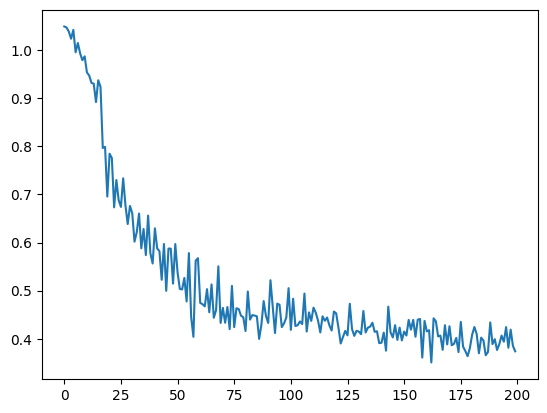

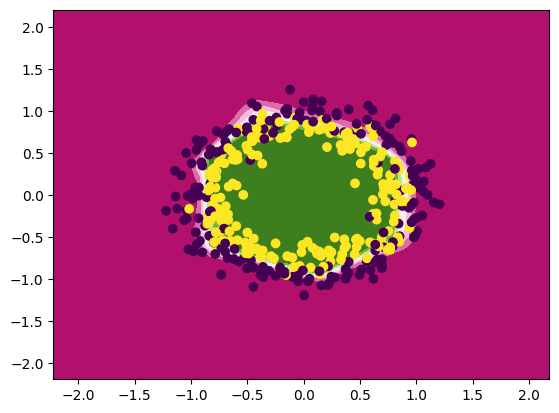

In [29]:
batch_size = 16
epochs = 200
losses = []
# Workspace 3.9
#BEGIN
losses = network.fit(circles_offset.X_train, circles_offset.y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs)
plt.plot(np.arange(len(losses)), losses)
plt.show()
#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

### Adam : Adaptive moment estimation (Bonus)
SGD optimizer the simplest we can use. However, the batch estimation of the gradient can be noisy. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer smoothes out the gradient
using a moving average of past gradients (first moment) and scales them using a moving average estimate of their norm (second moment).
It works as follows:

- Parameters: learning rate $\alpha$, decay rates $\beta_1$ and $\beta_2$.
- Initialize: $t=0$, $m = 0$, $v = 0$ (each network parameter should have its corresponding $m$ and $v$)
- For each `apply_gradient` call given gradient $g$ do:
    - $t \leftarrow t+1$
    - $m \leftarrow \beta_1 m + (1-\beta_1) g$
    - $v \leftarrow \beta_2 v + (1-\beta_2) g^2$
    - $\hat{m} \leftarrow \frac{1}{1 - \beta_1 ^ t} m$
    - $\hat{v} \leftarrow \frac{1}{1 - \beta_2 ^ t} v$
    - apply gradient $\alpha .\hat{m} / (\sqrt{\hat{v}} + \epsilon)$ (division and sqrt are element wise, epsilon is a small constant to avoid zero division, we'll use $\epsilon =10^{-8}$)
Refer to the original paper is there is any confusion around the iterations

**3.10 (Bonus Question) [5 points]** Complete Adam optimizer class and redo 3.9 using Adam optimizer instead. Try a learning rate that gave a bad performance using SGD.
Which optimizer is better? why?

In [30]:
class Adam(SGD):
    def __init__(self, learning_rate, beta_1, beta_2):
        super(Adam, self).__init__(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment = None
        self.second_moment = None
        self.time_step = 0
        self.gradients = []

    def apply_gradients(self):
        # Workspace 3.10.a
        #BEGIN

        self.time_step += 1
        if self.first_moment is None:
            self.first_moment = [[g * 0 for g in layer.parameters] for layer in self.layers]
            self.second_moment = [[g * 0 for g in layer.parameters] for layer in self.layers]

        for layer, moment_1, moment_2 in zip(self.layers, self.first_moment, self.second_moment):
            for i in range(len(layer.parameters)):
                moment_1[i] = self.beta_1 * moment_1[i] + (1 - self.beta_1) * layer.parameters[i].gradient
                moment_2[i] = self.beta_2 * moment_2[i] + (1 - self.beta_2) * layer.parameters[i].gradient ** 2
                moment_1_estimate = moment_1[i] / (1 - self.beta_1 ** self.time_step)
                moment_2_estimate = moment_2[i] / (1 - self.beta_2 ** self.time_step)
                gradient = self.learning_rate * moment_1_estimate / (moment_2_estimate ** 0.5 + 1e-8)
                layer.parameters[i].apply_gradient(-gradient)
        #END
        self.gradients = None

In [31]:
# Testing Adam optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[-0.07104128, 0.36260954], [-0.50247728, -0.46956692]])
adam_network = Network(Adam(1e-1, 0.9, 0.99), MSE())
np.random.seed(42), adam_network.add_layer(Dense(2, 2))
for _ in range(4):
    adam_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(adam_network.layers[0].weights, expected_weights))


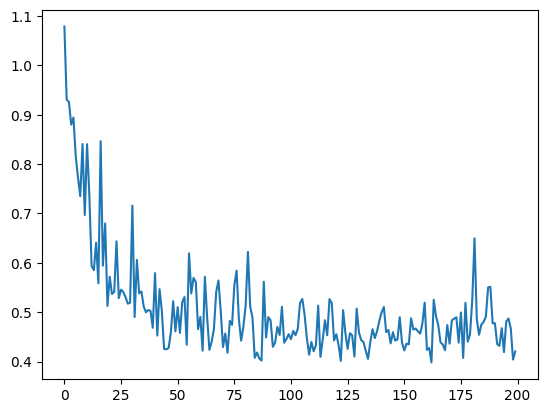

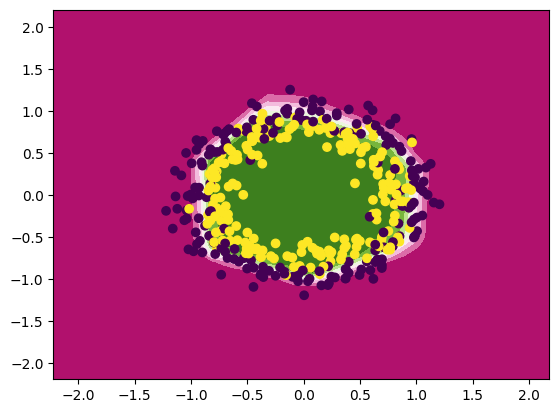

In [32]:
batch_size = 16
epochs = 200
losses = []
network = Network(optimizer=Adam(1e-1, 0.9, 0.99), loss=MSE())
# Workspace 3.10.b
#BEGIN

network.add_layer(Dense(input_dimension=2, output_dimension=32))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=32, output_dimension=64))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=64, output_dimension=1))
network.add_layer(Hyperbolic())
losses = network.fit(circles_offset.X_train, circles_offset.y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs)
plt.plot(np.arange(len(losses)), losses)
plt.show()
#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

### Workspace 3.10.c
% Which optimizer is better

%BEGIN

%END

### Bonus Problem: Deep Q-Learning (10 points)

This problem has a low [#points / effort] ratio, but we promise it's going to be fun and rewarding.
We'll start first by explaining two elements of Markov Decision Process (MDP): policy $\pi$ and its state-action functions $Q_\pi$.

In [33]:
import numpy as np
import data
import tests
import tqdm.notebook
import matplotlib.pyplot as plt

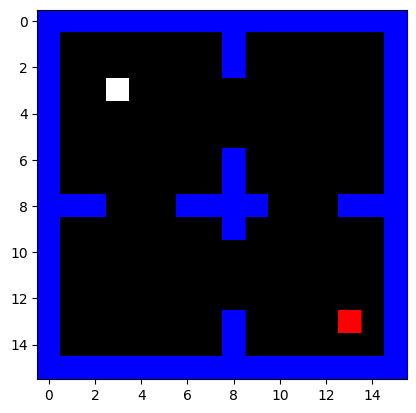

In [34]:
environment = data.GRID(grid_size=16, max_time=2000)
environment.reset()
environment.render()


We'll be using a _4-rooms_ environment where the goal of the agent (white square) is to reach the target (red square).
The grid is 16 by 16, so there are 256 states. Not all the states are accessible, since the agent can't cross the blue walls.
Each state $s$ is represented as a tuple $(x_s, y_s)$ that reflects the position of the agent.

There are 4 possible actions at each state (clockwise): Up (0), Right(1), Down(2), Left(3).
The agent gets a penalty (reward = -1) if it hits the blue walls and a reward = 1 if it reaches the target.
The episode ends (game over) when the target is reached or the agent has taken 2000 steps.

We will be using Q-learning to find a good policy that will allow us to reach the target before the time runs out.

At step $t$, the agent is located at state $s_t$ and chooses an action $a_t = \pi(s_t)$ following the policy $\pi$

The agent then gets reward $r_t$ and moves to state $s_{t+1}$. The process repeats until we reach a final state $s_T$ (`game_over == True`)

We'll call a replay a sequence of tuples $(s_t, a_t, r_t, s_{t+1})$.

Initial state:(3, 3)
Took action: Down
New state: (4, 3)
Reward: 0
Game over:False


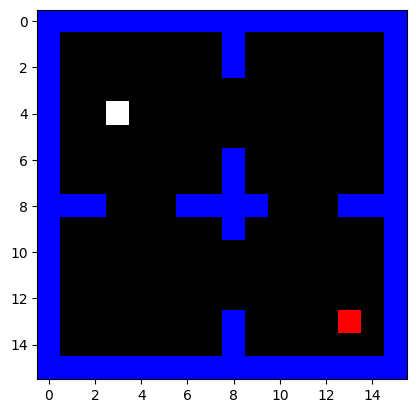

In [35]:
# How to create a replay with one element
# repeat as long as game_over is false
replay = []
current_state = environment.reset()
action = 2
print("Initial state:{}".format(current_state))
new_state, reward, game_over = environment.step(action)  # down
replay.append((current_state, action, reward, new_state))
current_state = new_state
print("Took action: {}".format(data.grid.ACTIONS_NAMES[action]))
print("New state: {}\nReward: {}\nGame over:{}".format(new_state, reward, game_over))
environment.render()

Starting at time $t=0$, The agent's goal is to maximize the expected discounted rewards:
\begin{align}
\eta_\pi = \sum_{t | a_t =\pi(s_t)} \gamma^t r_t
\end{align}
$0<\gamma<1$ is the discount rate. We'll be using $\gamma = 0.95$

The main role of discounting the rewards is to motivate the agent to achieve the goal as early as possible (no procrastination).

It makes reaching the goal at $t=1$, for example, more desirable than at $t=100$: $r_1=1$ contributes $\gamma^1 =0.95$ while $r_{100} = 1$ will only count as $\gamma^{100} =0.006$ in $\eta_\pi$.

$Q_\pi(s_t, a_t)$ is defined as the expected discounted rewards if we start at state $s_t$, take an initial actions $a_t$, and
follow the policy $\pi$ to decide the remaining action $(a_{t+1},..... a_{T-1})$.

\begin{align}
Q_\pi(s,a) = \eta_\pi, \text{ such that } s_0 = s \text{ and } a_0 = a
\end{align}

The principle behind Q-learning, as the name suggests, is to learn the optimal $Q^*$.
Since at each instant $t$, we want to pick the action that yields the best expected rewards, the optimal policy $\pi^*$ would be:
\begin{align}
\pi^*(s) = \arg\max_a Q^*(s, a)
\end{align}

__So how do we learn the optimal $Q^*$?__

By exploring the environment and saving a replay $\text{Replay} = \{(s_t, a_t, r_t, s_{t+1})| t\leq T\}$ (one that reaches the goal, hopefully),

we can use _Bellman equations_ to update our estimate of the $Q$ function in the following way:
\begin{align}
Q_{new}(s_t, a_t) \leftarrow r_t + \gamma \max_a Q_{old}(s_{t+1}, a), \;\;\; \forall \; (s_t, a_t, r_t, s_{t+1})\in \text{Replay}
\end{align}

We can prove that repeating this update will make our estimate converge to a unique optimal state-action value function $Q^*$.

Instead of "brutally" updating Q, we'll use a learning rate $\alpha$, so that the update would be :
\begin{align}
Q_{new}(s_t, a_t) \leftarrow  (1-\alpha)Q_{old}(s_t, a_t) + \alpha\big[r_t + \gamma \max_a Q_{old}(s_{t+1}, a) \big]
\end{align}

In this first part, we'll use an array `Q` of shape (16 x 16 x 4) to store $Q$, and the value $Q(s,a)$ would be accessed via `Q[x_s, y_s, a]`.

- 4.1 **[3 points]** Complete the class method `TabularQ.update` to apply _Bellman_ updates provided a replay

In [36]:
class TabularQ:
    def __init__(self, gamma=0.95, learning_rate=0.01):
        self.Q = np.zeros((16, 16, 4))
        self.gamma = gamma
        self.alpha = learning_rate

    def update(self, replay):
        for s_t, a_t, r_t, s_t_p_1 in replay:
            # Workspace 4.1
            #BEGIN
            s_x, s_y = s_t
            s_p_x, s_p_y = s_t_p_1
            self.Q[s_x, s_y, a_t] *= (1 - self.alpha)
            self.Q[s_x, s_y, a_t] += self.alpha * (r_t + self.gamma * np.max(self.Q[s_p_x, s_p_y]))
            #END

    def best_action(self, s):
        action = np.argmax(self.Q[s[0], s[1]])
        return action

    def save(self, checkpoint_name):
        np.savez_compressed(checkpoint_name, Q=self.Q)

    def load(self, checkpoint_name):
        self.Q = np.load(checkpoint_name +".npz" )["Q"]

class Policy():

    def __init__(self, Q, epsilon=1):
        self.Q = Q
        self.epsilon = epsilon

    def act(self, state):
        if np.random.uniform(0, 1) <= self.epsilon:
            return np.random.choice([0, 1, 2, 3])
        else:
            return self.Q.best_action(state)

Now we have to address a different question: when we explore the environment, how should we choose the actions?

One approach is to follow a $\epsilon$-greedy policy, where we choose a random action with probability $\epsilon$ and the best action according to Q with probability $1-\epsilon$.

For instance, if $\epsilon=1$, all actions are chosen randomly. For $\epsilon=0$, all actions are chosen _greedily_.
A common practice is to start with $\epsilon=1$ and decay it to 0 as we generate replays. How fast we decay it is related to the famous _exploration-exploitation_ dilemma in Reinforcement Learning.

4.2 **[2 points]** Complete the cell below to generate replays and update `tabular_Q` for `n_episodes`. You're free to choose your own decaying rate for $epsilon$ (including a 0 decay)


In [37]:
tabular_Q = TabularQ()

In [38]:
n_episodes = 20
greedy_policy = Policy(tabular_Q, epsilon=1.0)
decay = 0.995
def play(environment, policy):
    # Returns one episode's replay and the total accumulated rewards
    replay = []
    current_state = environment.reset()
    game_over = False
    total_rewards = 0
    while not game_over:
        action = policy.act(current_state)
        new_state, reward, game_over = environment.step(action)
        replay.append((current_state, action, reward, new_state))
        current_state = new_state
        total_rewards += reward
    return replay, total_rewards

for _ in range(n_episodes):
    # Workspace 4.2
    #BEGIN
    tabular_Q.update(play(environment, greedy_policy)[0])
    greedy_policy.epsilon *= decay
    #END

Now let's examine how the agent behaves a following random policy vs our Q-learning policy.

You should notice that if you run Q-learning multiple times, you might get different policies (different ways to reach the target) : we've mentioned before that $Q^*$ is unique, it's not the case for $\pi^*$

In [39]:
_ = play(environment, Policy(tabular_Q, epsilon=1.0)) # completely random policy
tests.save_frames(environment.episode, target_mp4="uniform") # saves the episode to uniform.mp4
tests.display_video("uniform") # display uniform.mp4

_Hint_ : if trained properly, you should expect "Best policy reached target after" < 30 steps

In [40]:
episode_length = len(play(environment, Policy(tabular_Q, epsilon=0.0))[0]) # optimal policy
tests.save_frames(environment.episode, target_mp4="best_tabular")
tests.display_video("best_tabular") # best_tabular.mp4
print("Best policy reached target after {} steps".format(episode_length))

Best policy reached target after 21 steps


- 4.3 **[1 point]** To get the full credit of the previous questions, you'll have to submit a zip file `q_learning.zip` that includes `uniform.mp4`, `best_tabular.mp4` from previous cells and `best_tabular.npz` from the cell below

_Hint_:  If cells ran correctly, the files should appear in the same path as the notebook

In [41]:
tabular_Q.save("best_tabular")

What made the tabular Q-learning more approachable is our knowledge of the state space. Our grid is 16 by 16, so there are 256 states in total (not all of them are accessible, due to the environment restrictions.)

In the next Deep Q-learning section, we add randomness to our environment. In our _random_ grid, the target and the agents are randomly located, that yields $256^2 = 65536$ states. Not outside the realm of a tabular Q, but we will try to avoid that.

When the grid is _random_, the state is no longer the (x,y) coordinates, but a 16x16 image of the environment


(16, 16, 3) 1.0 0.0


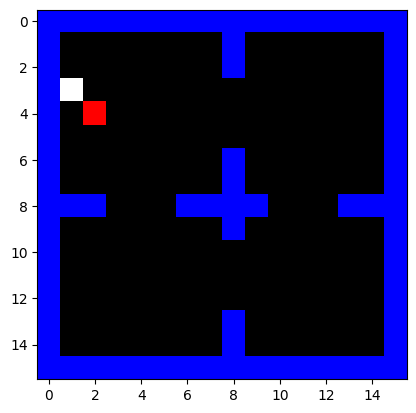

In [42]:
random_environment = data.GRID(grid_size=16, random=True, max_time=200)
s = random_environment.reset()
print(s.shape, s.max(), s.min())
plt.imshow(s)

In Deep Q learning, we model Q as neural network $Q_\theta$ where $\theta$ represent the network parameters.
The neural network takes the state image as input and outputs a 4-dimensional array $Q(s)$ where $Q(s)_i = Q(s, i) $ for $i\in[0,1,2,3]$.

Given a replay $Replay$, we will call an iteration:
- Get the current $Q$ values of the states $s_t$ : `Q_s`
- Get the current $Q$ values of the states $s_{t+1}$: `Q_s_p`
- Updates the element of `Q_s` following __Bellman__ method (you'll have to use `Q_s_p`, the replay actions and the rewards)
- Fit the neural network using the replays states and the computed `Q_s` for a single epoch

A single update might consist of several iterations ( do not confuse this with the neural network fit's epoch)

We'll be minimizing the objective
\begin{align}
    \mathcal{L}_\theta(\text{Replay}) = \sum_{(s_t, a_t, r_t, s_{t+1}) \in \text{Replay}} \mathcal{L}\big(Q_{\theta}(s_t, a_t) - \big[r_t + \gamma \max_a Q_\theta(s_{t+1}, a) \big] \big)
\end{align}
where $\mathcal{L}$ is a loss function.

In our implementation, we'll be using `Huber` loss. You're free to change the loss, the learning rate, and the network architecture. The ones provided bellow have been tested, and they're guaranteed to work

- 4.4 **[4 points]** Complete `DeepQ.update` to perform _Bellman_ iterations

In [43]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

class DeepQ:
    def __init__(self, gamma=0.95):
        self.neural_net = models.Sequential([layers.InputLayer(input_shape=(16, 16, 3)),
                                             data.get_inception_layer(32, 32, 32),
                                             layers.Conv2D(64, 2, 2, activation="relu"),
                                             data.get_inception_layer(32, 32, 32),
                                             layers.Conv2D(128, 2, 2, activation="relu"),
                                             layers.Conv2D(256, 2, 2, activation="relu"),
                                             layers.Flatten(),
                                             layers.Dense(256, activation="tanh"),
                                             layers.Dense(512),
                                             layers.Dense(4)])  # Do not change the model
        optimizer = optimizers.adam_v2.Adam(learning_rate=1e-4)  # You can change the learning rate
        self.neural_net.compile(loss=losses.Huber(), optimizer=optimizer)  # You can also change the loss function
        self.neural_net.summary()
        self.gamma = gamma

    def update(self, replay, iterations=2, batch_size=32):
        current_states = np.array([r[0] for r in replay])
        actions = np.array([r[1] for r in replay])
        rewards = np.array([r[2] for r in replay])
        next_states = np.array([r[3] for r in replay])

        loss = 0
        for _ in range(iterations):
            # Workspace 4.4
            # Todo: predict Q_s and Q_s_p
            # Use Q_s_p, actions, rewards to update Q_s and fit self.neural_network for one epoch
            # Q_s = None
            
            #BEGIN
            Q_s_p = self.neural_net.predict(next_states, batch_size=batch_size)
            Q_s = self.neural_net.predict(current_states, batch_size=batch_size)
            Q_s[np.arange(len(actions)), actions] = rewards + self.gamma * np.max(Q_s_p, axis=1)
            #END
            history = self.neural_net.fit(current_states, Q_s, epochs=1, batch_size=batch_size)
            loss += history.history["loss"][0]
        print("Loss:", loss / iterations)

    def best_action(self, s):
        # We want to allow some noise in the estimation
        q = self.neural_net.predict(s[None, :])[0]
        q_max = np.max(q)
        possible_actions = np.where(np.abs(q - q_max) < 0.05 * np.std(q))[0]
        return np.random.choice(possible_actions)

    def checkpoint(self, checkpoint_path):
        self.neural_net.save_weights(checkpoint_path)

    def load(self, checkpoint_path):
        self.neural_net.load_weights(checkpoint_path)


In [44]:
deep_Q = DeepQ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_layer (InceptionL  (None, 16, 16, 99)       2112      
 ayer)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          25408     
                                                                 
 inception_layer_1 (Inceptio  (None, 8, 8, 160)        43104     
 nLayer)                                                         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         82048     
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         131328    
                                                                 
 flatten (Flatten)           (None, 1024)              0

2022-11-14 18:34:47.557361: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Feel free to tweak the training parameters if you think it would improve learning. The provided ones have been tested and they should work.

In [45]:
greedy_policy = Policy(deep_Q, epsilon=1.0)
# Tweak the next parameters to improve the learning
n_episodes = 80
steps_per_replay = 8000
decay= 0.995

In [46]:
for e in range(n_episodes):
    replay = []
    episode = []
    rewards = 0
    pbar = tqdm.notebook.tqdm(desc="Generating replay", total=steps_per_replay)
    while len(replay) < steps_per_replay:
        rep, rew = play(random_environment, greedy_policy)
        episode += random_environment.episode
        replay += rep
        rewards += rew
        pbar.update(len(rep))
    pbar.close()
    tests.save_frames(episode, "currently_training") # save video of last episodes played

    print("episode", e + 1,"/",n_episodes,", eps:", greedy_policy.epsilon, "total rewards:", rewards)
    deep_Q.update(replay, iterations=4)
    greedy_policy.epsilon *= decay

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

4.5 [**1 point**] To be considered for full credit, include `deep_q.mp4` and the `checkpoint` folder in your submitted `q_learning.zip`

_Hint_ : if trained properly, you should expect `"Total rewards over 10 episodes` > 75

In [ ]:
short_random_environment = data.GRID(random=True, max_time=100)
episodes = []
deep_best_policy = Policy(deep_Q, epsilon=0)
rewards = 0
for _ in tqdm.notebook.tqdm(range(10)):
    rewards += play(short_random_environment, deep_best_policy)[1]
    episodes += short_random_environment.episode
print("Total rewards over 10 episodes:", rewards)
tests.save_frames(episodes, "deep_q")

In [ ]:
tests.display_video("deep_q")

In [ ]:
deep_Q.checkpoint("checkpoint/deep_q")